# 한국어 Embedding 
---
Word2Vec을 활용한 네이버 영화 리뷰 데이터 한국어 Embedding

### 데이터 불러오기 및 정규화

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x1c21651f9a0>)

In [3]:
train_data = pd.read_table('ratings.txt')
train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [4]:
print(len(train_data)) # 리뷰 개수 출력

200000


#### 결측값(null값) 확인 및 제거

In [5]:
print(train_data.isnull().values.any())

True


In [6]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any())     # Null 값이 존재하는지 확인

False


In [7]:
print(len(train_data)) # 리뷰 개수 재확인

199992


#### 한글 외 문자열 제거

In [8]:
train_data['document'] = train_data['document'].str.replace('[^ㄱ-하-ㅣ가-힣]', '')
train_data[:5]

C:\Users\User\AppData\Local\Temp\ipykernel_18016\3447951904.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('[^ㄱ-하-ㅣ가-힣]', '')


,id,document,label
0,8112052,어릴때보고지금다시봐도재밌어요ㅋㅋ,1
1,8132799,디자인을배우는학생으로외국디자이너와그들이일군전통을통해발전해가는문화산업이부러웠는데사실우...,1
2,4655635,폴리스스토리시리즈는부터뉴까지버릴께하나도없음최고,1
3,9251303,와연기가진짜개쩔구나지루할거라고생각했는데몰입해서봤다그래이런게진짜영화지,1
4,10067386,안개자욱한밤하늘에떠있는초승달같은영화,1


In [9]:
# 학습 제외 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

### 형태소 분석

In [10]:
# 진행 상황 확인을 위한 라이브러리 import
from tqdm import tqdm

In [12]:
okt = Okt()
tokenized_data = []

for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem = True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    tokenized_data.append(stopwords_removed_sentence)

100%|████████████████████████████████████████████████████████████████████████| 199992/199992 [1:12:10<00:00, 46.18it/s]


리뷰의 최대 길이:  68
리뷰의 평균 길이:  10.685057402296092


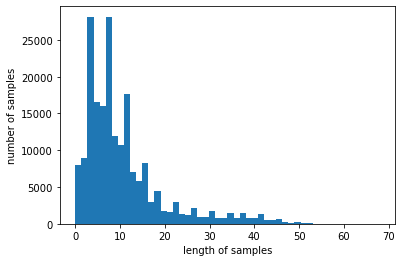

In [15]:
# 토큰화 분포 확인

print("리뷰의 최대 길이: ", max(len(l) for l in tokenized_data))
print("리뷰의 평균 길이: ", sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel("length of samples")
plt.ylabel("number of samples")  
plt.show()

### Word2Vec 활용 네이버 영화 리뷰 데이터 학습

In [16]:
from gensim.models.word2vec import Word2Vec

In [20]:
model = Word2Vec(sentences=tokenized_data,             
                 sg=0,               # 0: CBOW, 1: skip-gram
                 vector_size=100,    # 벡터 크기
                 window=5,           # 고려할 앞뒤 폭
                 min_count=5,        # 사용할 단어의 최소 빈도(5회 이하 단어 무시)
                 workers=4           # 동시에 처리할 작업 수(코어 수와 비슷하게 설정)
                )

In [21]:
model.wv.vectors.shape

(17961, 100)

#### wv 메소드로 유사어 확인

In [22]:
model.wv.most_similar("최민식")

[('정재영', 0.8597306609153748),
 ('김명민', 0.8548922538757324),
 ('한석규', 0.8531215786933899),
 ('안성기', 0.8425782322883606),
 ('엄태웅', 0.8421011567115784),
 ('이정재', 0.8409314751625061),
 ('엄정화', 0.8361085057258606),
 ('설경구', 0.8340092301368713),
 ('윤제문', 0.8336495161056519),
 ('신들리다', 0.8330317735671997)]

In [23]:
model.wv.most_similar("히어로")

[('느와르', 0.8785941004753113),
 ('호러', 0.8738062381744385),
 ('무협', 0.8712169528007507),
 ('블록버스터', 0.8551961779594421),
 ('슬래셔', 0.8407227396965027),
 ('무비', 0.8332386016845703),
 ('헐리우드', 0.8312457799911499),
 ('물', 0.8184596300125122),
 ('멜로', 0.8146000504493713),
 ('홍콩', 0.8100864887237549)]

In [24]:
model.wv.most_similar(positive=['남자', '공주'], negative=['여자'])

[('왕자', 0.7852778434753418),
 ('변호사', 0.781938910484314),
 ('선수', 0.7732151746749878),
 ('박사', 0.7663156390190125),
 ('동갑', 0.7657095789909363),
 ('유리', 0.7430212497711182),
 ('아가씨', 0.7393375635147095),
 ('미녀', 0.7377999424934387),
 ('도자기', 0.7377309799194336),
 ('선배', 0.7356462478637695)]

### 사전 학습 Word2Vec 가져오기
---
한글 사전 학습 word2Vec

Korean (w) 경로: https://drive.google.com/file/d/0B0ZXk88koS2KbDhXdWg1Q2RydlU/view

ko.zip을 다운받아 압축을 풀면 50MB 가량의 ko.bin 파일이 생긴다. 이 파일은 .load로 불러들일 수 있다.

import numpy
kovec = Word2Vec.load('ko.bin 파일 경로')

kovec.wv.most_similar(positive=['일본', '서울'], negative=['한국'])